In [2]:
import numpy as np
import pandas as pd
import imputation as imp
import forecasting as fc
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt
import time
from codecarbon import EmissionsTracker

In [ ]:
df = pd.read_csv("datasets/genome/electricity_cleaned.csv", index_col='timestamp', parse_dates=True)
df = df.select_dtypes(include="number")
metadata = pd.read_csv("datasets/genome/metadata.csv")

df.head()

,Panther_parking_Lorriane,Panther_lodging_Cora,Panther_office_Hannah,Panther_lodging_Hattie,Panther_education_Teofila,Panther_education_Jerome,Panther_retail_Felix,Panther_parking_Asia,Panther_education_Misty,Panther_retail_Gilbert,...,Cockatoo_public_Caleb,Cockatoo_education_Tyler,Cockatoo_public_Shad,Mouse_health_Buddy,Mouse_health_Modesto,Mouse_lodging_Vicente,Mouse_health_Justin,Mouse_health_Ileana,Mouse_health_Estela,Mouse_science_Micheal
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,123.200,727.575,69.200,8.8224,370.0870,10.0,282.9965,26.0,135.0,168.2243
2016-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,126.475,731.200,66.275,17.6449,737.8260,30.0,574.9265,51.0,265.0,336.4486
2016-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,127.825,724.675,64.675,17.6449,729.9255,30.0,570.2780,50.0,272.0,336.4486
2016-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130.475,737.375,65.875,17.6449,722.2620,20.0,561.1470,52.0,276.0,336.4486
2016-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,129.675,721.150,66.275,17.6449,719.1665,30.0,564.3695,50.0,280.0,336.4486


In [20]:
site_ids = metadata["site_id"].unique()
print(site_ids)

target_site = "Panther"
cols = [col for col in df.columns if col.startswith(target_site)]
df = df[cols]

['Panther' 'Robin' 'Fox' 'Rat' 'Bear' 'Lamb' 'Peacock' 'Moose' 'Gator'
 'Bull' 'Bobcat' 'Crow' 'Shrew' 'Swan' 'Wolf' 'Hog' 'Eagle' 'Cockatoo'
 'Mouse']


In [21]:
imputation_methods = {
    "LOCF": imp.locf,
    "NOCB": imp.nocb,
    "Linear Interpolation": imp.linear_interpolation,
    "Linear Regression": imp.linear_regression,
    "LightGBM": imp.lightgbm,
}
rng = np.random.default_rng(seed=42)
target = rng.choice(cols)
print("Selected:", target)

imputed = {}
performance = {}
df_masked, samples = imp.create_mcar_data(df, missing=0.2, seed=42)

for n, f in imputation_methods.items():
    tracker = EmissionsTracker(
        project_name=n,
        output_dir="performance",
        output_file="genome_codecarbon.csv",
    )
    # Start time and emission trackers
    tracker.start()
    start_time = time.time()

    df_imputed = f(df_masked.copy())

    # Stop trackers
    end_time = time.time()
    emissions = tracker.stop()

    # Store imputed data in dictionary
    imputed[n] = df_imputed

    # Get error metrics only for the masked values
    i = df.columns.get_loc(target)
    mask = samples[:, i]
    y_true = df.values[:, i][mask]
    y_pred = df_imputed.values[:, i][mask]

    valid = (~np.isnan(y_true)) & (~np.isnan(y_pred))
    y_true = y_true[valid]
    y_pred = y_pred[valid]

    # Compute error
    mae = mean_absolute_error(y_true, y_pred)
    nrmse = root_mean_squared_error(y_true, y_pred) / (np.max(y_true) - np.min(y_true))

    performance[n] = {
        "MAE": mae,
        "NRMSE": nrmse,
    }

[codecarbon WARNING @ 16:26:07] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 16:26:07] [setup] RAM Tracking...
[codecarbon INFO @ 16:26:07] [setup] CPU Tracking...


Selected: Panther_retail_Gilbert


[codecarbon WARNING @ 16:26:08] We saw that you have a AMD Ryzen 5 7530U with Radeon Graphics but we don't know it. Please contact us.
[codecarbon WARNING @ 16:26:08] We will use the default power consumption of 4 W per thread for your 12 CPU, so 48W.
[codecarbon WARNING @ 16:26:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 16:26:08] CPU Model on constant consumption mode: AMD Ryzen 5 7530U with Radeon Graphics
[codecarbon WARNING @ 16:26:08] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 16:26:08] [setup] GPU Tracking...
[codecarbon INFO @ 16:26:08] No GPU found.
[codecarbon INFO @ 16:26:08] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: cpu_load
                GPU Tracking Method: Unspecified

[LightGBM] [Info] Total Bins 25936
[LightGBM] [Info] Number of data points in the train set: 11283, number of used features: 104
[LightGBM] [Info] Start training from score 10.713786
[LightGBM] [Info] Total Bins 25913
[LightGBM] [Info] Number of data points in the train set: 11422, number of used features: 104
[LightGBM] [Info] Start training from score 134.915551
[LightGBM] [Info] Total Bins 25901
[LightGBM] [Info] Number of data points in the train set: 11232, number of used features: 104
[LightGBM] [Info] Start training from score 6.693737
[LightGBM] [Info] Total Bins 25903
[LightGBM] [Info] Number of data points in the train set: 11308, number of used features: 104
[LightGBM] [Info] Start training from score 140.595259
[LightGBM] [Info] Total Bins 25919
[LightGBM] [Info] Number of data points in the train set: 11229, number of used features: 104
[LightGBM] [Info] Start training from score 156.395496
[LightGBM] [Info] Total Bins 25908
[LightGBM] [Info] Number of data points in the t

[codecarbon INFO @ 16:27:08] Energy consumed for RAM : 0.000043 kWh. RAM Power : 10.0 W


[LightGBM] [Info] Total Bins 25906
[LightGBM] [Info] Number of data points in the train set: 11319, number of used features: 104
[LightGBM] [Info] Start training from score 602.109280
[LightGBM] [Info] Total Bins 25904
[LightGBM] [Info] Number of data points in the train set: 11323, number of used features: 104
[LightGBM] [Info] Start training from score 163.741249


[codecarbon INFO @ 16:27:08] Delta energy consumed for CPU with cpu_load : 0.000117 kWh, power : 27.1296 W
[codecarbon INFO @ 16:27:08] Energy consumed for All CPU : 0.000117 kWh
[codecarbon INFO @ 16:27:08] 0.000160 kWh of electricity used since the beginning.


[LightGBM] [Info] Total Bins 25920
[LightGBM] [Info] Number of data points in the train set: 11327, number of used features: 104
[LightGBM] [Info] Start training from score 14.109885
[LightGBM] [Info] Total Bins 25908
[LightGBM] [Info] Number of data points in the train set: 11307, number of used features: 104
[LightGBM] [Info] Start training from score 100.150851
[LightGBM] [Info] Total Bins 25911
[LightGBM] [Info] Number of data points in the train set: 11246, number of used features: 104
[LightGBM] [Info] Start training from score 93.227259
[LightGBM] [Info] Total Bins 25914
[LightGBM] [Info] Number of data points in the train set: 11230, number of used features: 104
[LightGBM] [Info] Start training from score 107.825404
[LightGBM] [Info] Total Bins 25711
[LightGBM] [Info] Number of data points in the train set: 7092, number of used features: 104
[LightGBM] [Info] Start training from score 217.801693
[LightGBM] [Info] Total Bins 25911
[LightGBM] [Info] Number of data points in the t

[codecarbon INFO @ 16:27:23] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W


[LightGBM] [Info] Total Bins 25893
[LightGBM] [Info] Number of data points in the train set: 11364, number of used features: 104
[LightGBM] [Info] Start training from score 89.803805


[codecarbon INFO @ 16:27:23] Delta energy consumed for CPU with cpu_load : 0.000114 kWh, power : 28.317 W
[codecarbon INFO @ 16:27:23] Energy consumed for All CPU : 0.000231 kWh
[codecarbon INFO @ 16:27:23] 0.000314 kWh of electricity used since the beginning.


[LightGBM] [Info] Total Bins 25899
[LightGBM] [Info] Number of data points in the train set: 11292, number of used features: 104
[LightGBM] [Info] Start training from score 130.900100
[LightGBM] [Info] Total Bins 25907
[LightGBM] [Info] Number of data points in the train set: 11377, number of used features: 104
[LightGBM] [Info] Start training from score 22.095601
[LightGBM] [Info] Total Bins 26032
[LightGBM] [Info] Number of data points in the train set: 11321, number of used features: 104
[LightGBM] [Info] Start training from score 82.521643
[LightGBM] [Info] Total Bins 25904
[LightGBM] [Info] Number of data points in the train set: 11318, number of used features: 104
[LightGBM] [Info] Start training from score 32.174166
[LightGBM] [Info] Total Bins 25916
[LightGBM] [Info] Number of data points in the train set: 11322, number of used features: 104
[LightGBM] [Info] Start training from score 113.467565
[LightGBM] [Info] Total Bins 25897
[LightGBM] [Info] Number of data points in the t

[codecarbon INFO @ 16:27:31] Energy consumed for RAM : 0.000106 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:27:32] Delta energy consumed for CPU with cpu_load : 0.000057 kWh, power : 25.022399999999998 W
[codecarbon INFO @ 16:27:32] Energy consumed for All CPU : 0.000288 kWh
[codecarbon INFO @ 16:27:32] 0.000395 kWh of electricity used since the beginning.


[LightGBM] [Info] Total Bins 25996
[LightGBM] [Info] Number of data points in the train set: 14035, number of used features: 104
[LightGBM] [Info] Start training from score 0.567292
[LightGBM] [Info] Total Bins 25971
[LightGBM] [Info] Number of data points in the train set: 14035, number of used features: 104
[LightGBM] [Info] Start training from score 0.785425
[LightGBM] [Info] Total Bins 26520
[LightGBM] [Info] Number of data points in the train set: 14035, number of used features: 104
[LightGBM] [Info] Start training from score 0.785028
[LightGBM] [Info] Total Bins 26520
[LightGBM] [Info] Number of data points in the train set: 14035, number of used features: 104
[LightGBM] [Info] Start training from score 0.827961
[LightGBM] [Info] Total Bins 26509
[LightGBM] [Info] Number of data points in the train set: 14035, number of used features: 104
[LightGBM] [Info] Start training from score 0.816308


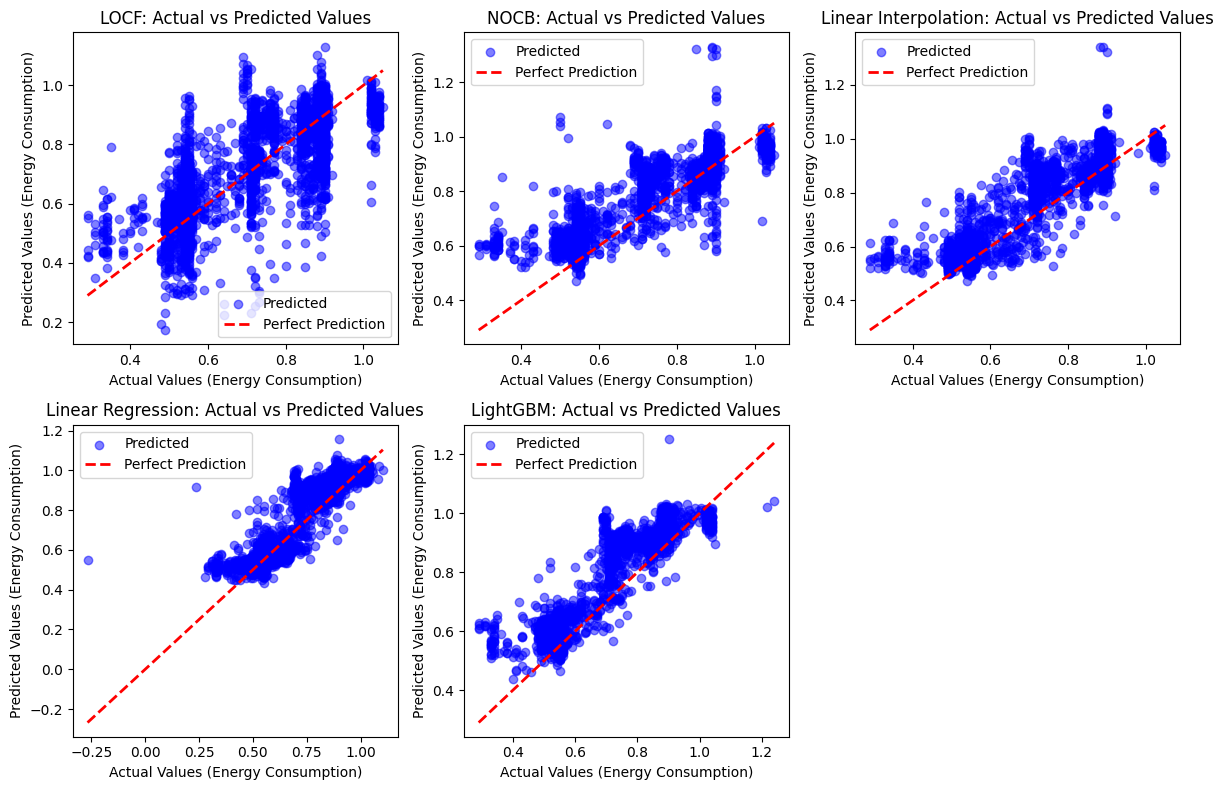

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()
forecasting = {}
features = [col for col in df.columns if col != target]

for i, (name, df_imputed) in enumerate(imputed.items()):
    X = df_imputed[features]
    y = df_imputed[target]

    X_train, X_test, y_train, y_test = fc.split_data(X, y, train_size=0.8)

    model = LGBMRegressor(force_col_wise=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    axs[i].scatter(y_test, y_pred, alpha=0.5, label="Predicted", color="b")
    axs[i].plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        "r--",
        lw=2,
        label="Perfect Prediction",
    )
    axs[i].set_xlabel("Actual Values (Energy Consumption)")
    axs[i].set_ylabel("Predicted Values (Energy Consumption)")
    axs[i].set_title(f"{name}: Actual vs Predicted Values")
    axs[i].legend()


axs[-1].axis("off")

plt.tight_layout()
plt.savefig("performance/figures/genome/forecasting.png")
plt.show()

In [23]:
df_performance = pd.DataFrame.from_dict(performance, orient="index")
df_performance

,MAE,NRMSE
LOCF,0.048840,0.090774
NOCB,0.045223,0.086682
Linear Interpolation,0.034791,0.054039
Linear Regression,0.069937,0.073607
LightGBM,0.033052,0.043035


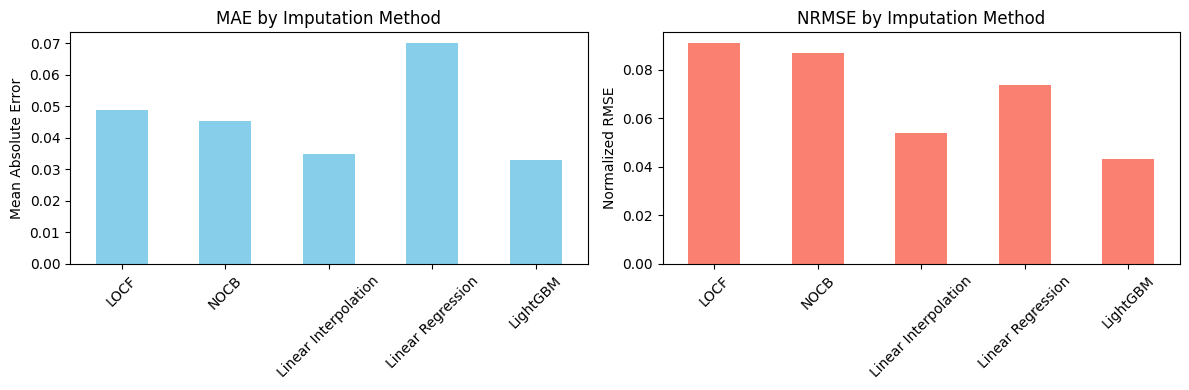

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

df_performance["MAE"].plot(kind="bar", ax=axs[0], color="skyblue")
axs[0].set_title("MAE by Imputation Method")
axs[0].set_ylabel("Mean Absolute Error")
axs[0].set_xticklabels(df_performance.index, rotation=45)

df_performance["NRMSE"].plot(kind="bar", ax=axs[1], color="salmon")
axs[1].set_title("NRMSE by Imputation Method")
axs[1].set_ylabel("Normalized RMSE")
axs[1].set_xticklabels(df_performance.index, rotation=45)

plt.tight_layout()
plt.savefig("performance/figures/genome/error.png")
plt.show()

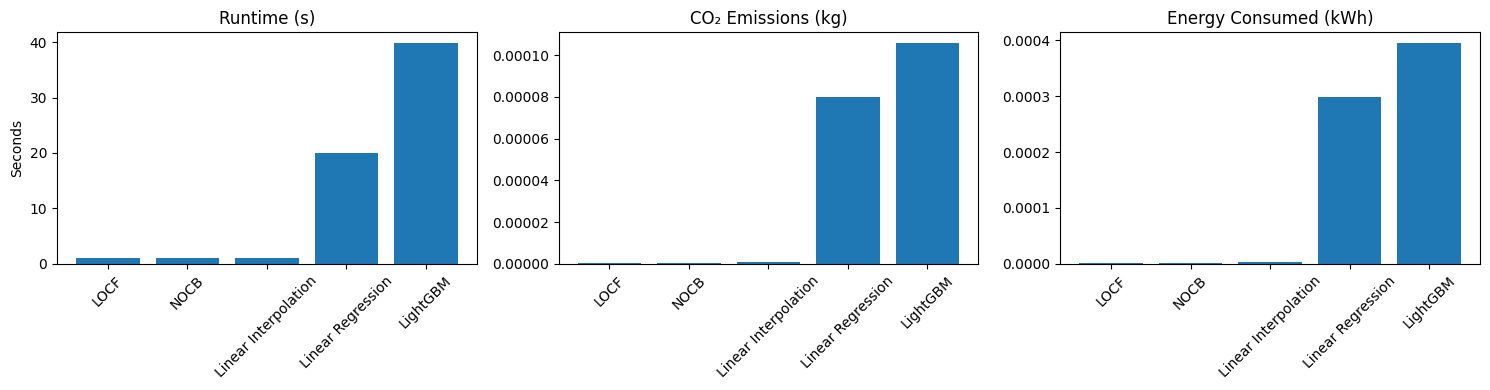

In [26]:
df_emission = pd.read_csv("performance/genome_codecarbon.csv")
df_emission_cleaned = df_emission[["project_name", "duration", "emissions", "energy_consumed"]]
df_emission_cleaned = df_emission_cleaned.set_index("project_name")

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].bar(df_emission_cleaned.index, df_emission_cleaned["duration"])
axs[0].set_title("Runtime (s)")
axs[0].set_ylabel("Seconds")
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(df_emission_cleaned.index, df_emission_cleaned["emissions"])
axs[1].set_title("CO₂ Emissions (kg)")
axs[1].tick_params(axis='x', rotation=45)

axs[2].bar(df_emission_cleaned.index, df_emission_cleaned["energy_consumed"])
axs[2].set_title("Energy Consumed (kWh)")
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("performance/figures/genome/emissions.png")
plt.show()